# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [4]:
#import data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']


/var/folders/mv/by660v2j6m5gb1c1bkdgq8lw0000gn/T/ipykernel_94193/317921284.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(handle)


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


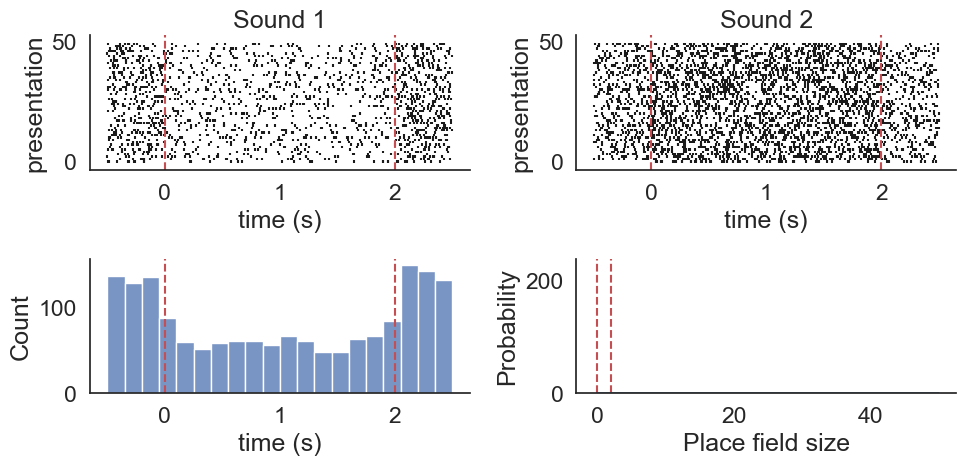

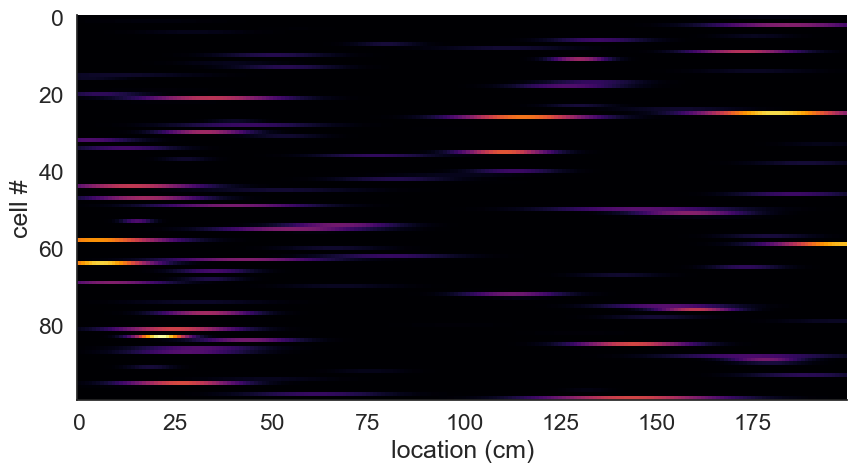

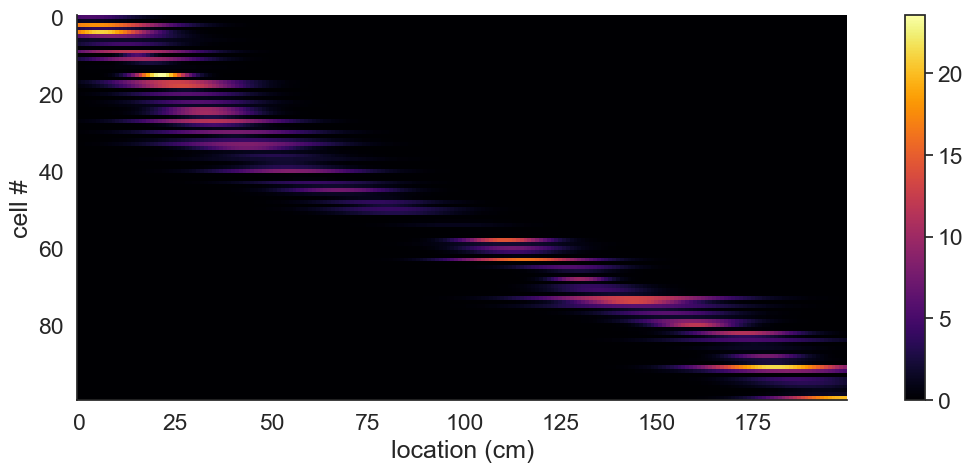

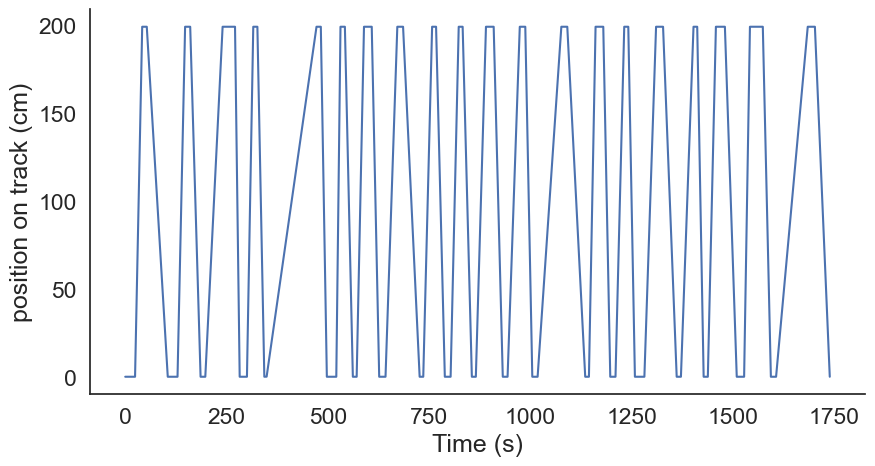

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

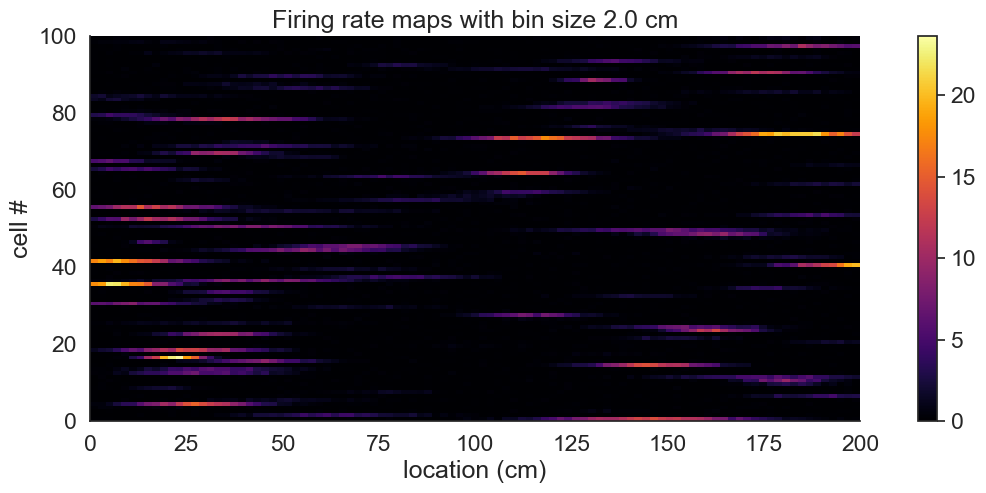

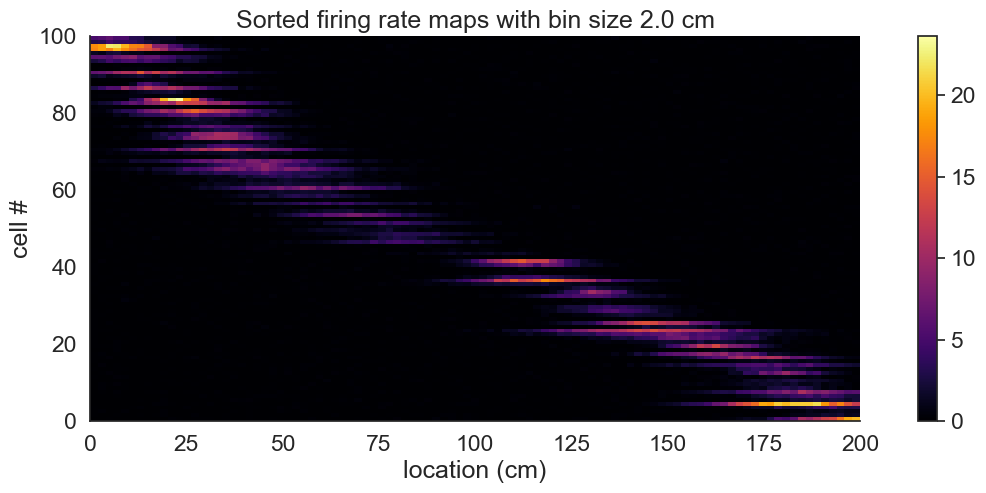

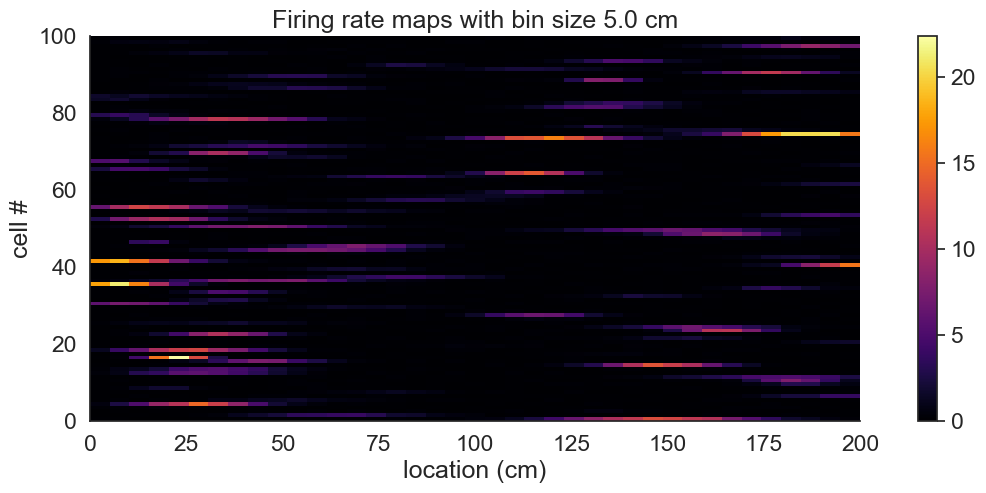

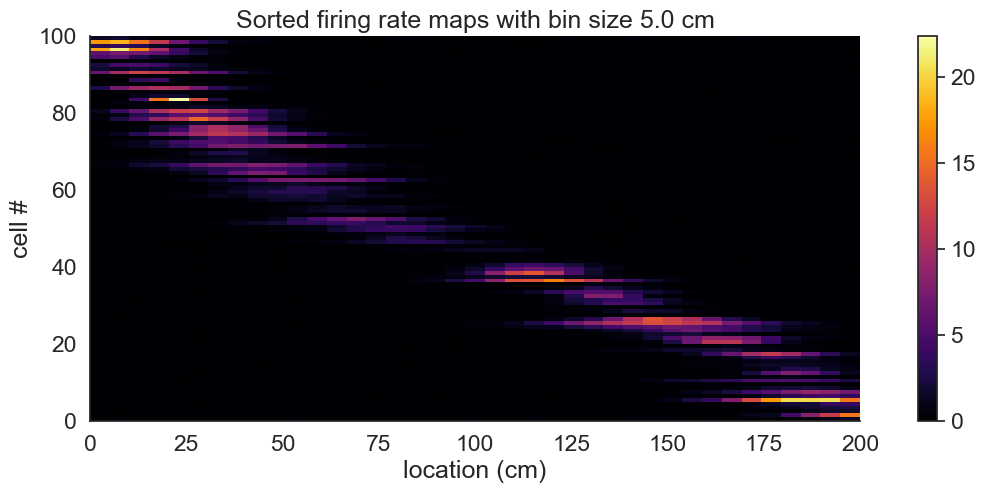

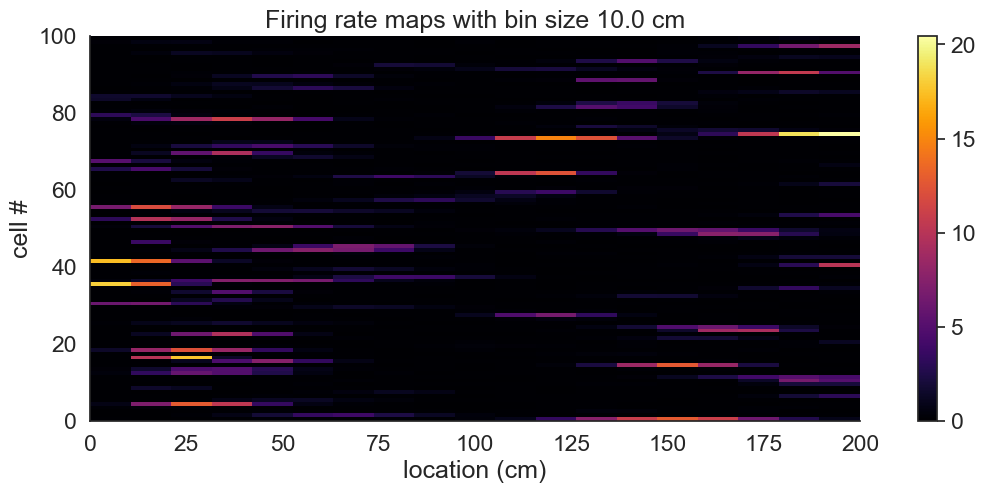

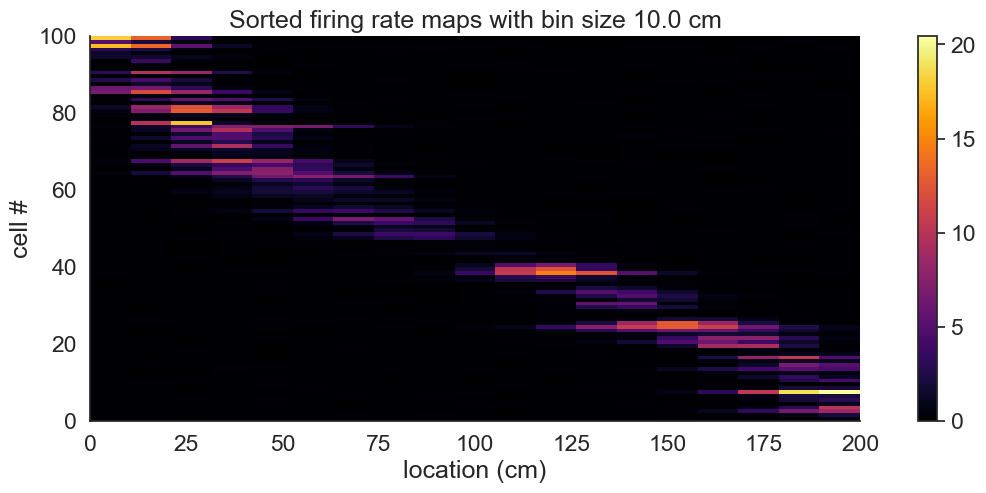

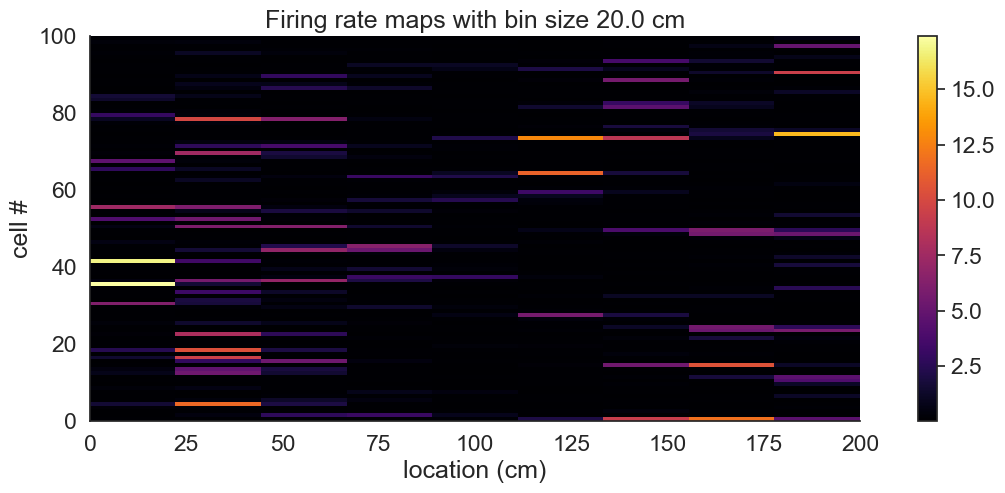

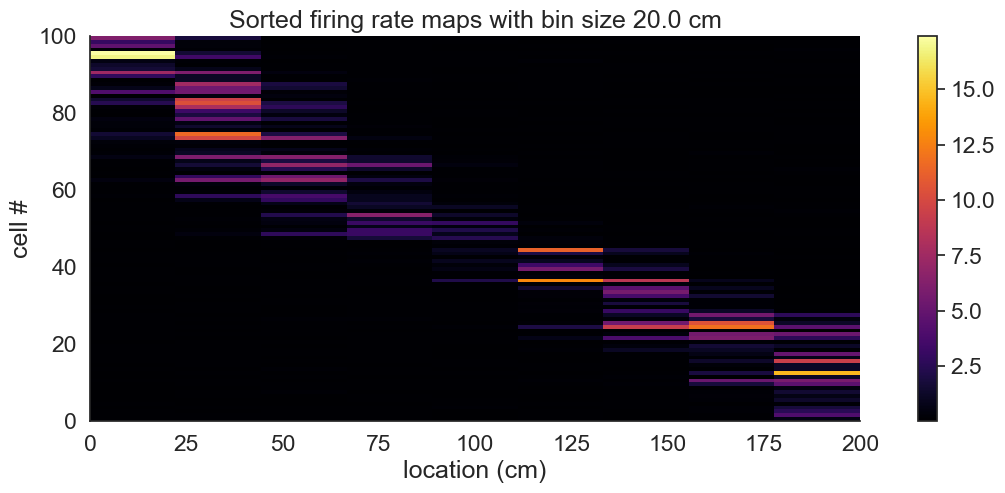

In [5]:
# PART A
# Cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration + 0.5

aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type == 1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset + psth_offset
        stim_spikes = [spike - stim_onset for spike in cell_spikes if (spike >= onset and spike < offset)]
        aligned_spikes.append(stim_spikes)
    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim2_onsets = stim_onsets[stim_type == 2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim2_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset + psth_offset
        stim_spikes = [spike - stim_onset for spike in cell_spikes if (spike >= onset and spike < offset)]
        aligned_spikes.append(stim_spikes)
    aligned_spikes_stim2.append(aligned_spikes)

neuron = 6  # neuron to plot

psth_spikes_stim1 = [item for sublist in aligned_spikes_stim1[neuron] for item in sublist]
psth_spikes_stim2 = [item for sublist in aligned_spikes_stim2[neuron] for item in sublist]

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.title('Sound 1')
plt.eventplot(aligned_spikes_stim1[neuron], color='k')
plt.axvline(x=0, linestyle='--', c='r')
plt.axvline(x=2, linestyle='--', c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2, 2, 2)
plt.title('Sound 2')
plt.eventplot(aligned_spikes_stim2[neuron], color='k')
plt.axvline(x=0, linestyle='--', c='r')
plt.axvline(x=2, linestyle='--', c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2, 2, 3)
sns.histplot(psth_spikes_stim1, bins=20)
plt.axvline(x=0, linestyle='--', c='r')
plt.axvline(x=2, linestyle='--', c='r')
plt.xlabel('time (s)')

plt.subplot(2, 2, 4)
sns.histplot(psth_spikes_stim2, bins=20)
plt.axvline(x=0, linestyle='--', c='r')
plt.axvline(x=2, linestyle='--', c='r')
plt.xlabel('time (s)')

plt.tight_layout()

track_length = 200.  # the length of our linear track (eg in centimeter)
average_firing_rate = 5  # the peak firing rate, averaged across the population
n_cells = 100  # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length  # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells)  # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)  # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1)  # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i, :] = pf_rate[i] * np.exp(-((bins - pf_centers[i]) ** 2) / (2 * pf_size[i] ** 2))

plt.figure(figsize=(10, 5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

plt.figure(figsize=(15, 5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix, :], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

n_runs = 20
av_running_speed = 10  # the average running speed (in cm/s)
fps = 30  # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs)  # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs)  # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i] * fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins) - 1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i] * fps),)) * (len(bins) - 1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins) - 1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x)) / fps

plt.figure(figsize=(10, 5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1  # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate / sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

def plot_unit(i):
    plt.figure(figsize=(10, 5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')

interact(plot_unit, i=widgets.IntSlider(min=0, max=(n_cells - 1), value=0))

spike_positions = [np.interp(s, t, x) for s in spikes]

# Explore different binning resolutions
bin_sizes = [2., 5., 10., 20.]

for bin_size in bin_sizes:
    space_bins = np.arange(0., 200., bin_size)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy

    plt.figure(figsize=(15, 5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Firing rate maps with bin size {bin_size} cm')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

    plt.figure(figsize=(15, 5))
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix, :], cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Sorted firing rate maps with bin size {bin_size} cm')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

plt.show()

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


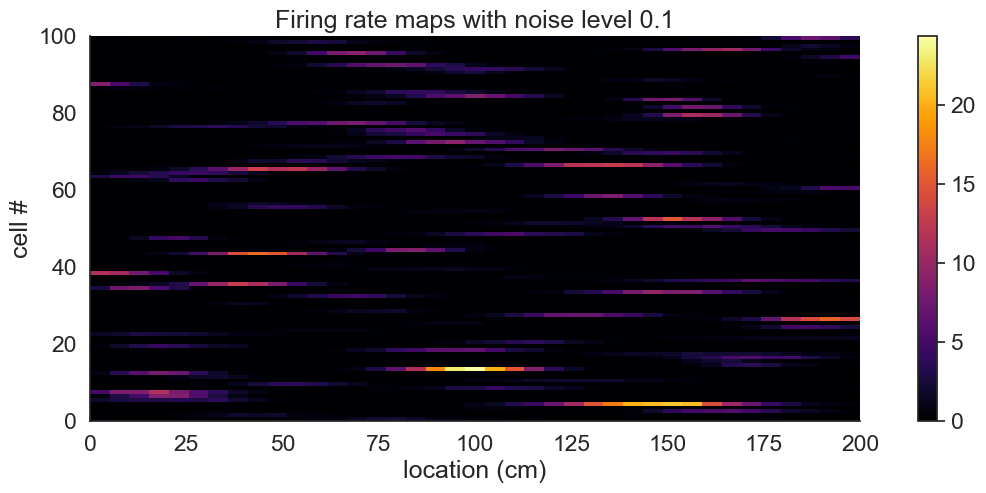

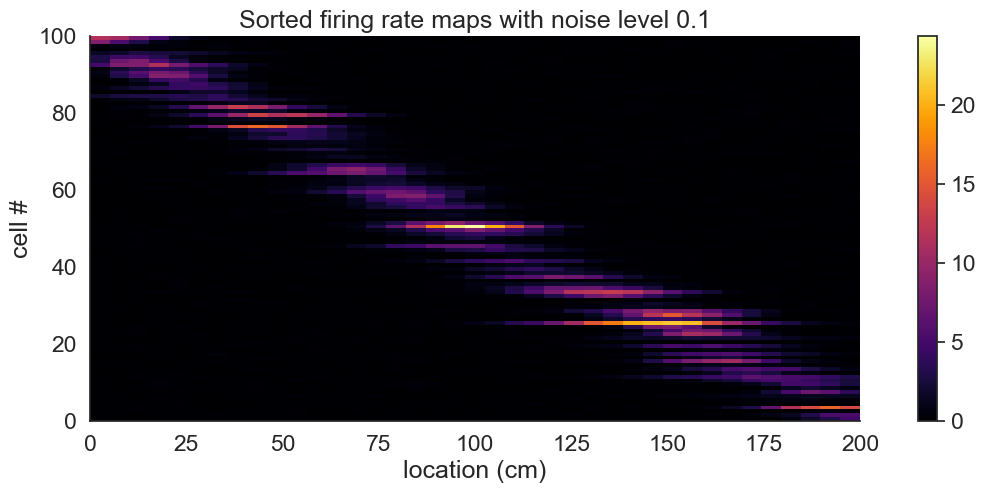

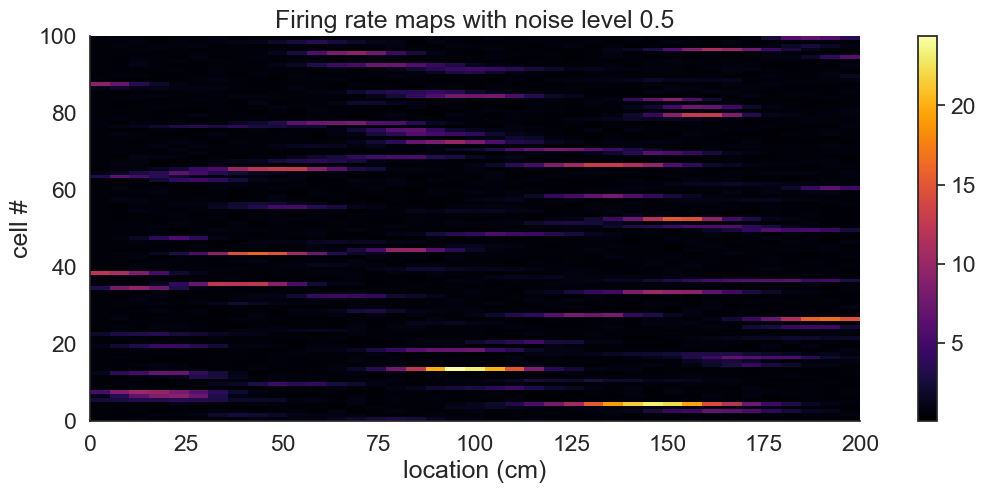

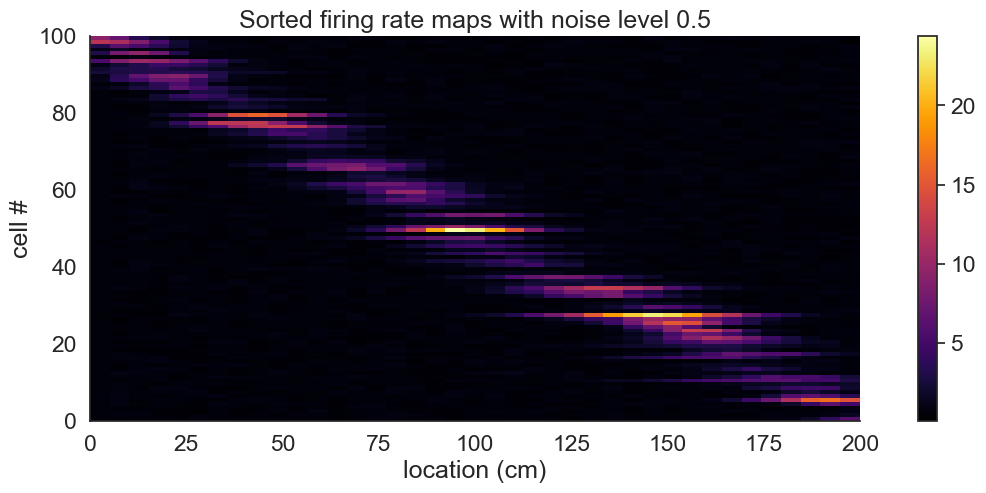

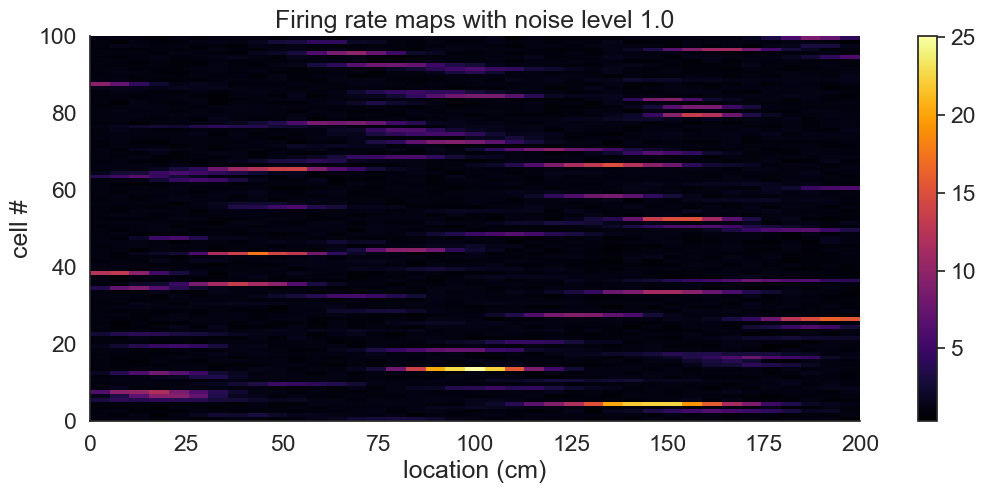

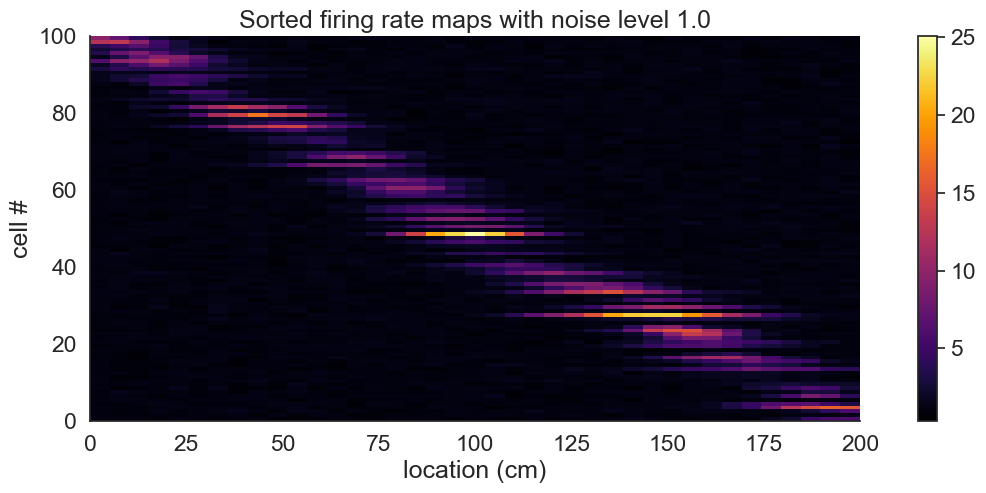

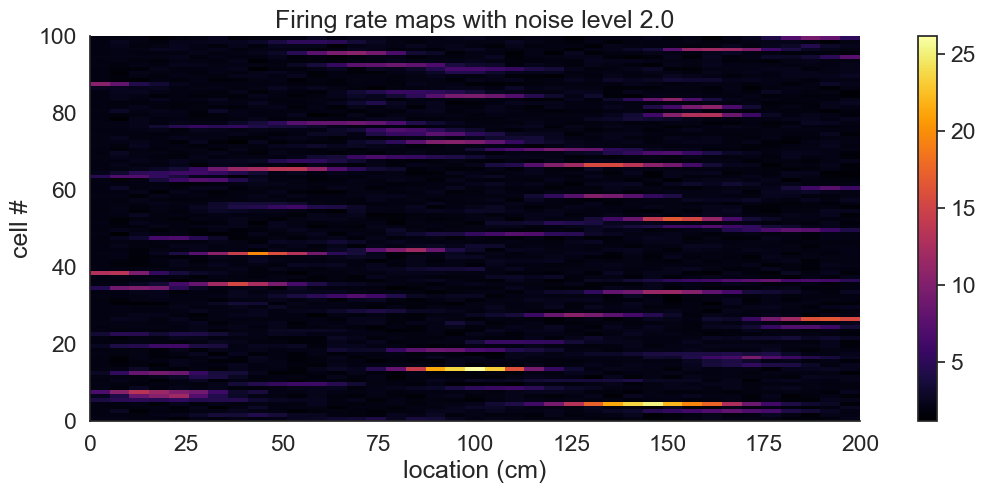

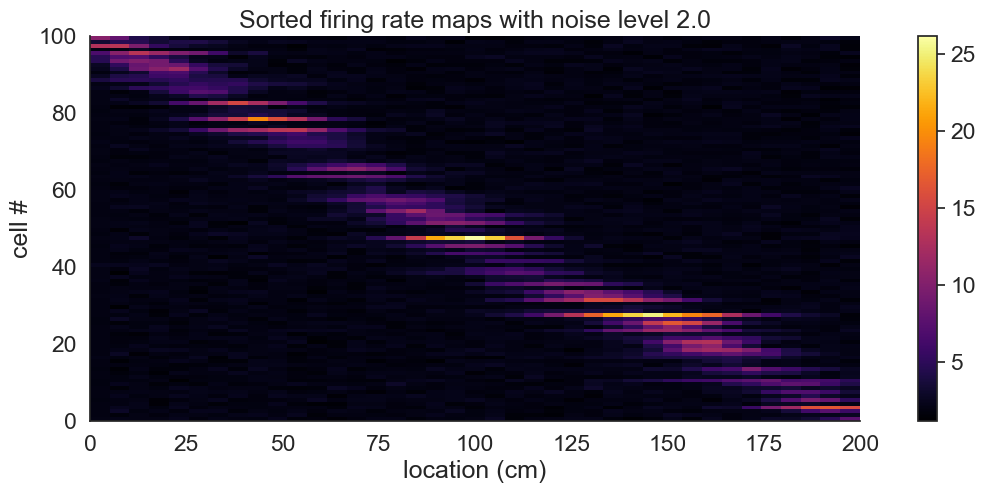

In [6]:
# PART B
# Experiment with different noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]

for noise_firing_rate in noise_levels:
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]

    space_bins = np.arange(0., 200., 5.)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy

    plt.figure(figsize=(15, 5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Firing rate maps with noise level {noise_firing_rate}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

    plt.figure(figsize=(15, 5))
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix, :], cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Sorted firing rate maps with noise level {noise_firing_rate}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

plt.show()

The variable noise_firing_rate determines the baseline noise level in the spike train simulations. 
- Low noise (0.1): The firing rate maps are clearer, with distinct peaks corresponding to the place fields. The noise level is low enough that it does not significantly interfere with the place-related firing patterns.
- Moderate noise (0.5): The firing rate maps start to show more background activity, but the place fields are still distinguishable. The noise begins to blend with the place-related activity, making the peaks less sharp.
- High noise (1.0 and 2.0): The firing rate maps become more smeared, with less distinct place fields. The noise dominates the maps, making it difficult to distinguish the true place-related firing patterns. When the noise is high, the best approach to obtaining meaningful firing rate maps is to use smoothing techniques. Smoothing can help reduce the impact of noise by averaging the firing rates over neighboring bins, thus highlighting the underlying place-related firing patterns. Additionally, increasing the bin size can help mitigate the noise effects, though this may reduce the spatial resolution of the firing rate maps.

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


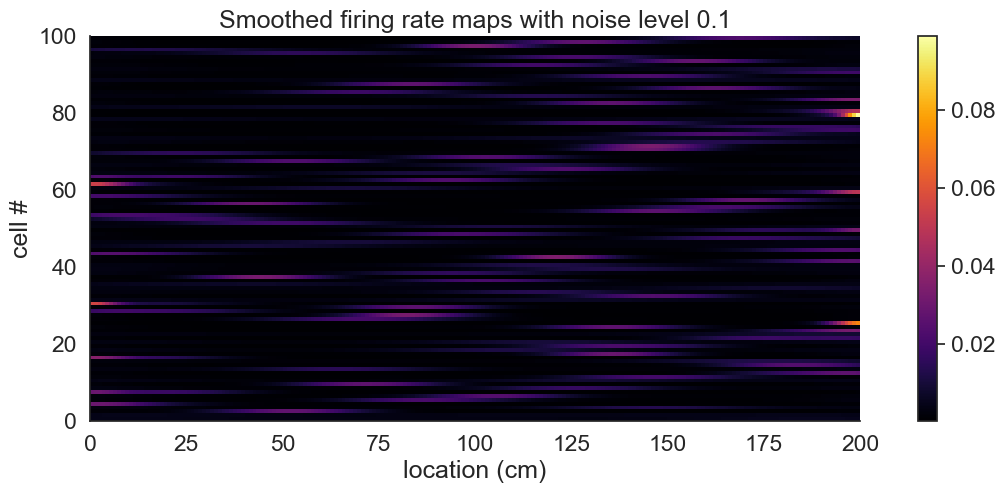

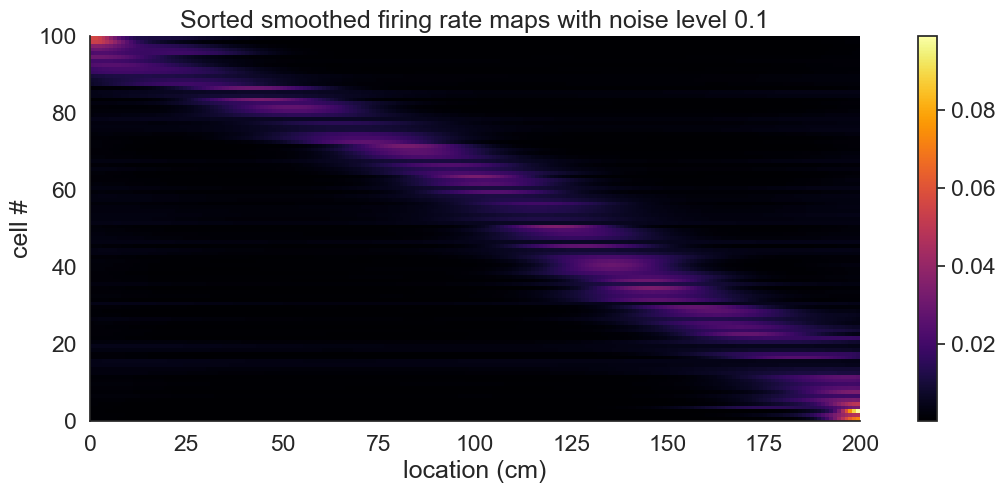

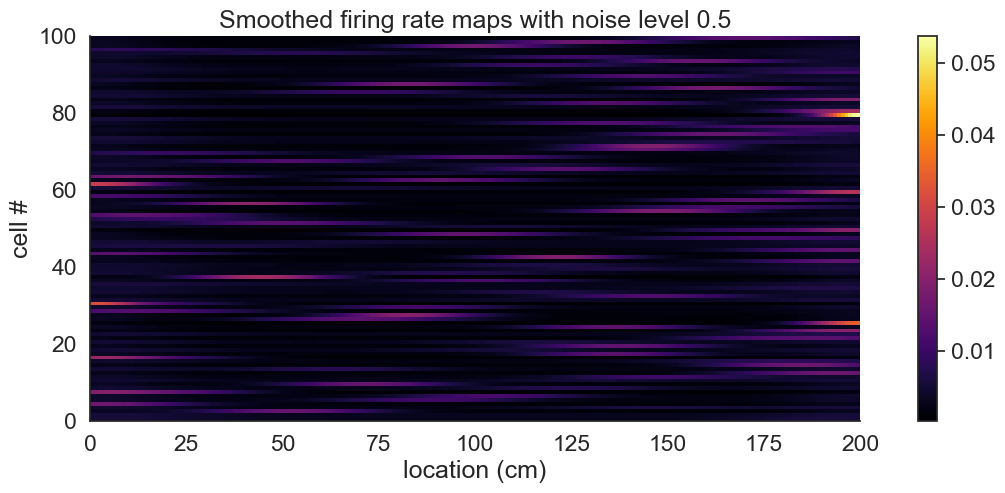

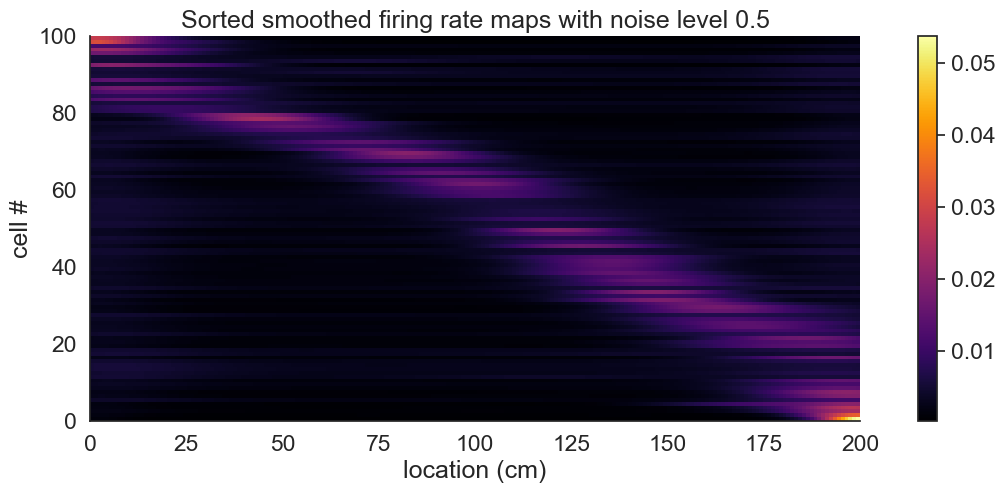

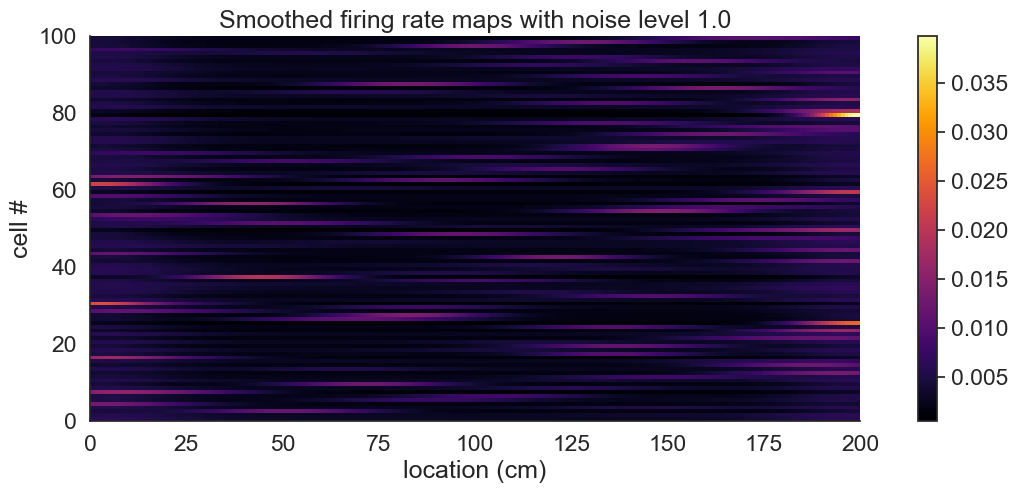

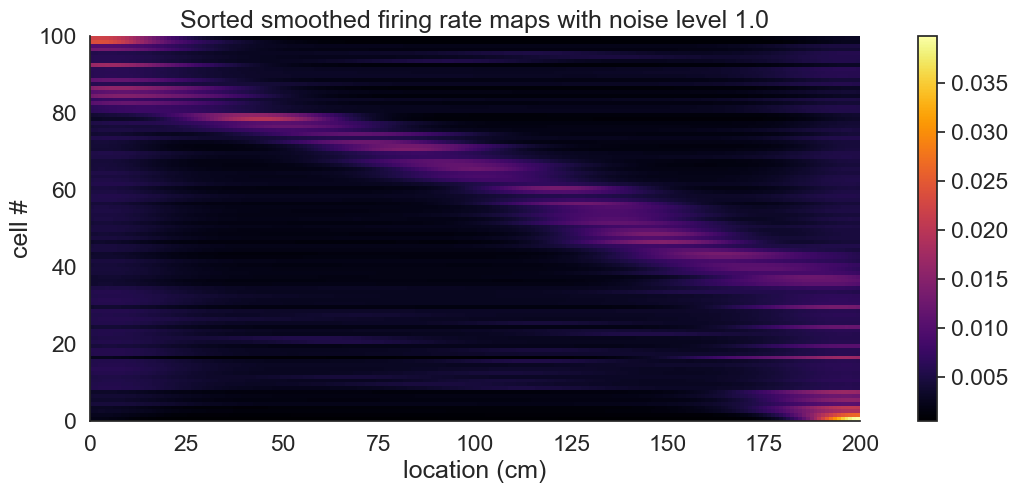

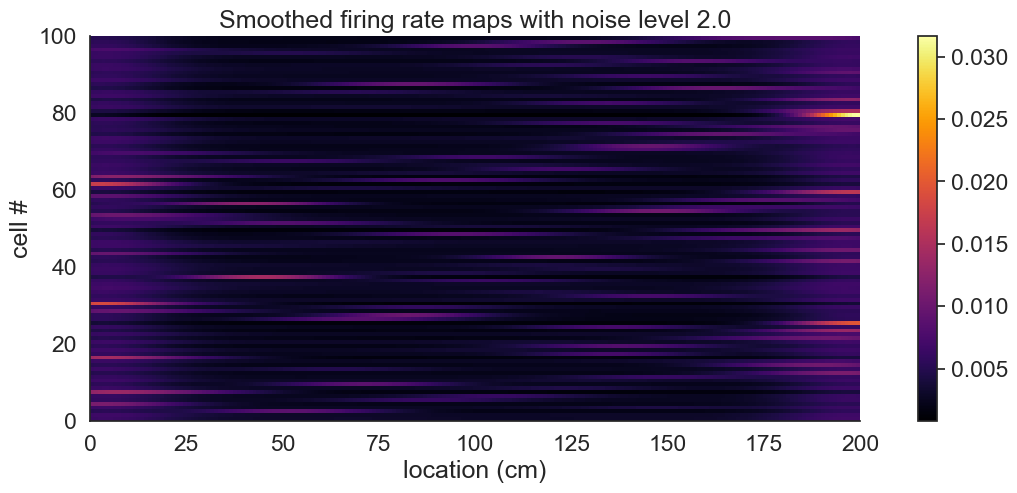

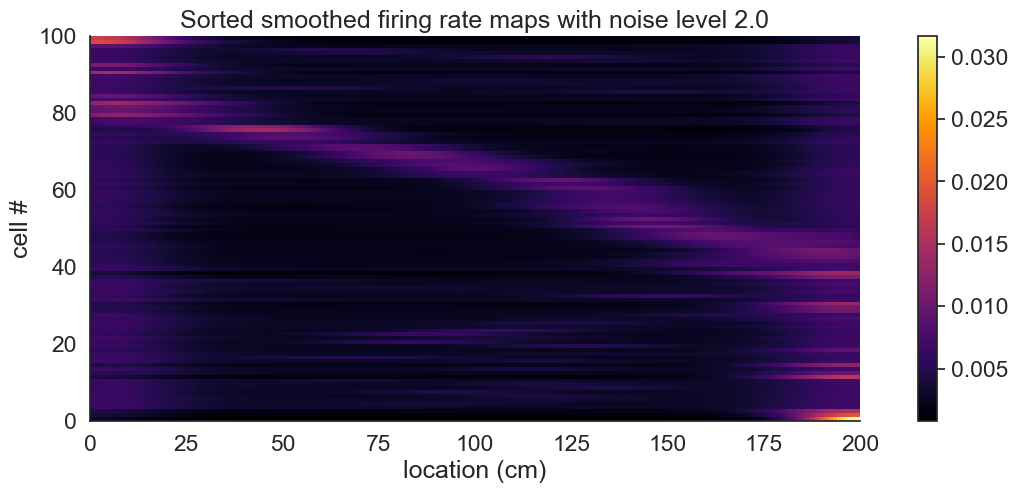

In [7]:
# PART C
# Experiment with different noise levels and apply Gaussian smoothing
noise_levels = [0.1, 0.5, 1.0, 2.0]
space_bins = np.arange(0., 200., 1.)  # 1 cm binning

for noise_firing_rate in noise_levels:
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp.flatten())

    spike_positions = [np.interp(s, t, x) for s in spikes]

    # Apply Gaussian smoothing
    firing_rate_maps = np.zeros((n_cells, len(space_bins)-1))
    for i in range(n_cells):
        kde = scipy.stats.gaussian_kde(spike_positions[i], bw_method='scott')
        firing_rate_maps[i, :] = kde(space_bins[:-1])

    plt.figure(figsize=(15, 5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Smoothed firing rate maps with noise level {noise_firing_rate}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

    plt.figure(figsize=(15, 5))
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix, :], cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Sorted smoothed firing rate maps with noise level {noise_firing_rate}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

plt.show()



Using the Gaussian smoother scipy.stats.gaussian_kde allows to create smoothed firing rate maps with fine binning (1 cm). By applying this smoother, it can better highlight the underlying firing patterns even in the presence of noise.

When the noise levels are low, the smoothed firing rate maps show clear and distinct place fields. As the noise level increases, the place fields become less distinct, but the Gaussian smoothing helps mitigate the noise by spreading the spikes' influence over a wider area, thus making the true place-related activity more apparent.

The best approach when the noise is high is to use fine binning combined with Gaussian smoothing. This method reduces the noise's impact on the firing rate maps, providing a clearer picture of the underlying neural activity.

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.30it/s]


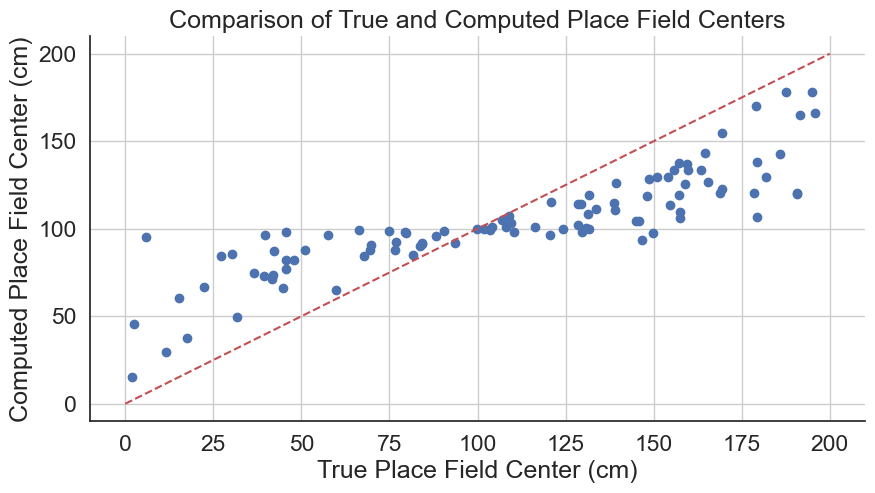

In [8]:
# PART D
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats
from ipywidgets import interact
import ipywidgets as widgets

# Define initial parameters
track_length = 200.  # cm
average_firing_rate = 5  # Hz
n_cells = 100  # number of cells
pf_centers = np.random.rand(n_cells) * track_length  # true center of place fields
pf_size = np.random.gamma(10, size=n_cells)  # size of place fields
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)  # peak firing rate

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i, :] = pf_rate[i] * np.exp(-((bins - pf_centers[i]) ** 2) / (2 * pf_size[i] ** 2))

n_runs = 20
fps = 30
running_speed_a = np.random.chisquare(10, size=n_runs)
running_speed_b = np.random.chisquare(10, size=n_runs)
stopping_time_a = np.random.chisquare(15, size=n_runs)
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i] * fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins) - 1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i] * fps),)) * (len(bins) - 1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins) - 1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x)) / fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))

noise_firing_rate = 0.5
spikes = []
for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate / sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp.flatten())

spike_positions = [np.interp(s, t, x) for s in spikes]

# Calculate place field centers using center of mass formula
computed_pf_centers = np.array([np.sum(spike_pos) / len(spike_pos) if len(spike_pos) > 0 else 0 for spike_pos in spike_positions])

# Plot true vs. computed place field centers
plt.figure(figsize=(10, 5))
plt.scatter(pf_centers, computed_pf_centers)
plt.plot([0, 200], [0, 200], 'r--')
plt.xlabel('True Place Field Center (cm)')
plt.ylabel('Computed Place Field Center (cm)')
plt.title('Comparison of True and Computed Place Field Centers')
plt.grid(True)
plt.show()


I calculated the computed place field centers for each cell and compared them with the true place field centers (stored in the variable pf_centers).

The plot shows a comparison between the true place field centers and the computed place field centers. The red dashed line represents the line of equality (where true and computed centers would be identical). Ideally, the points should lie close to this line, indicating good agreement between the true and computed centers. Discrepancies should indicate noise effects or differences in the spike distribution.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

/var/folders/mv/by660v2j6m5gb1c1bkdgq8lw0000gn/T/ipykernel_94193/1496020576.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(handle)
100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


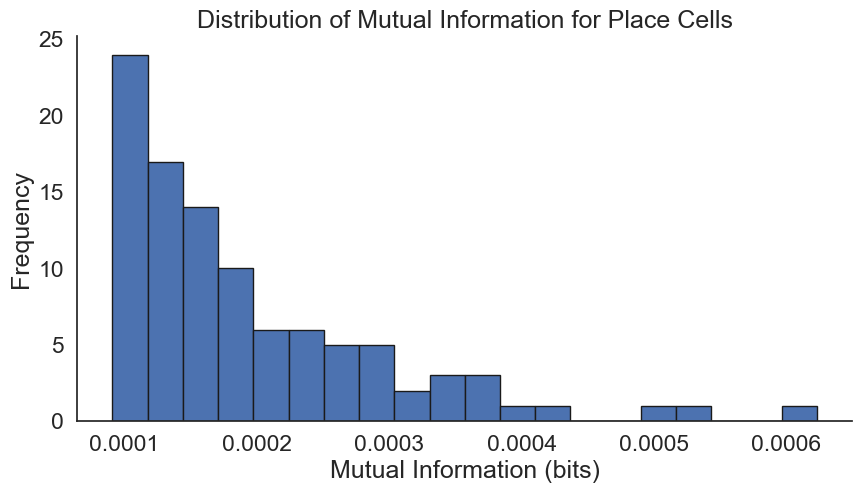

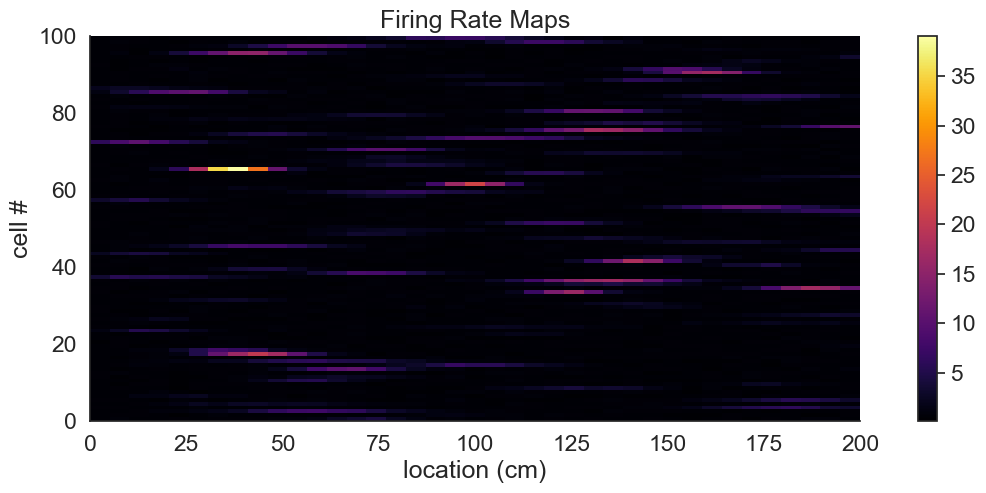

In [13]:
# PART A
# Mutual information calculation
def mutual_information(x, y):
    joint_prob, _, _ = np.histogram2d(x, y, bins=[space_bins, space_bins])
    joint_prob = joint_prob / np.sum(joint_prob)
    px = np.sum(joint_prob, axis=1)
    py = np.sum(joint_prob, axis=0)
    px_py = np.outer(px, py)

    non_zero_indices = joint_prob > 0
    mutual_info = np.sum(joint_prob[non_zero_indices] * np.log2(joint_prob[non_zero_indices] / px_py[non_zero_indices]))
    
    return mutual_info

# Resample spike positions to have the same length as x_sampling
def resample_spike_positions(spike_pos, target_length):
    if len(spike_pos) > target_length:
        spike_pos = np.random.choice(spike_pos, target_length, replace=False)
    elif len(spike_pos) < target_length:
        spike_pos = np.pad(spike_pos, (0, target_length - len(spike_pos)), 'edge')
    return spike_pos

resampled_spike_positions = [resample_spike_positions(spike_positions[i], len(x_sampling)) for i in range(n_cells)]
mutual_info_values = [mutual_information(resampled_spike_positions[i], x_sampling) for i in range(n_cells)]

plt.figure(figsize=(10, 5))
plt.hist(mutual_info_values, bins=20, edgecolor='k')
plt.xlabel('Mutual Information (bits)')
plt.ylabel('Frequency')
plt.title('Distribution of Mutual Information for Place Cells')
plt.show()

# Plot firing rate maps for reference
plt.figure(figsize=(15, 5))
plt.imshow(firing_rate_maps, cmap='inferno', extent=[0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.title('Firing Rate Maps')
plt.show()


100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


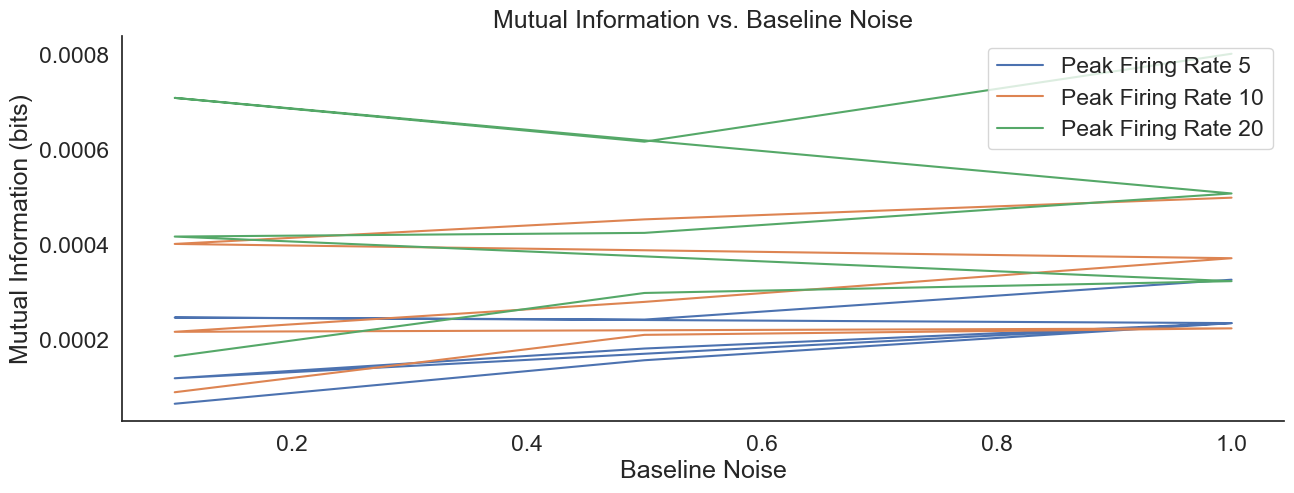

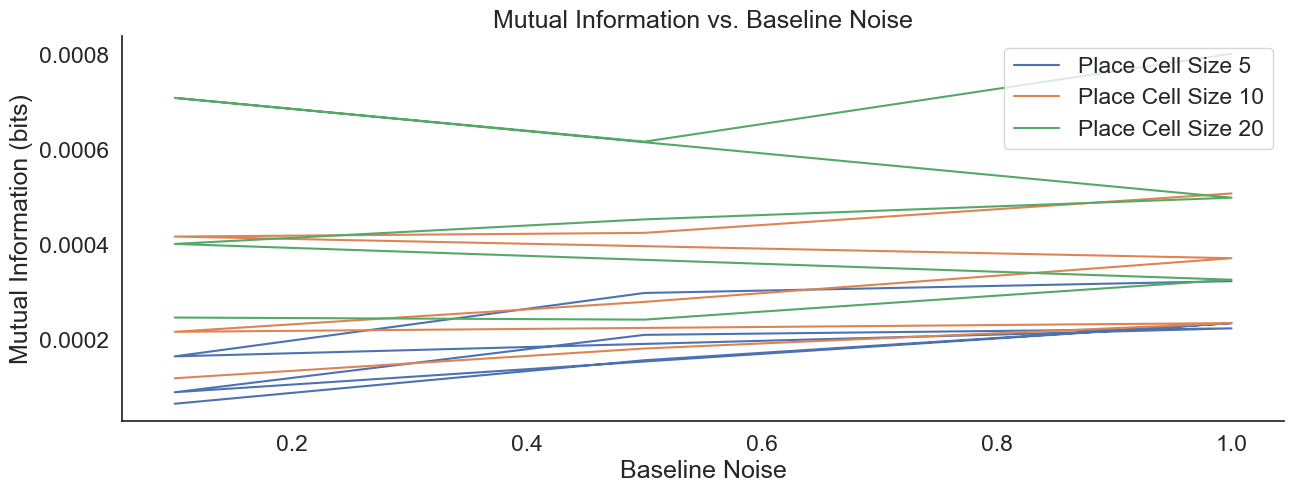

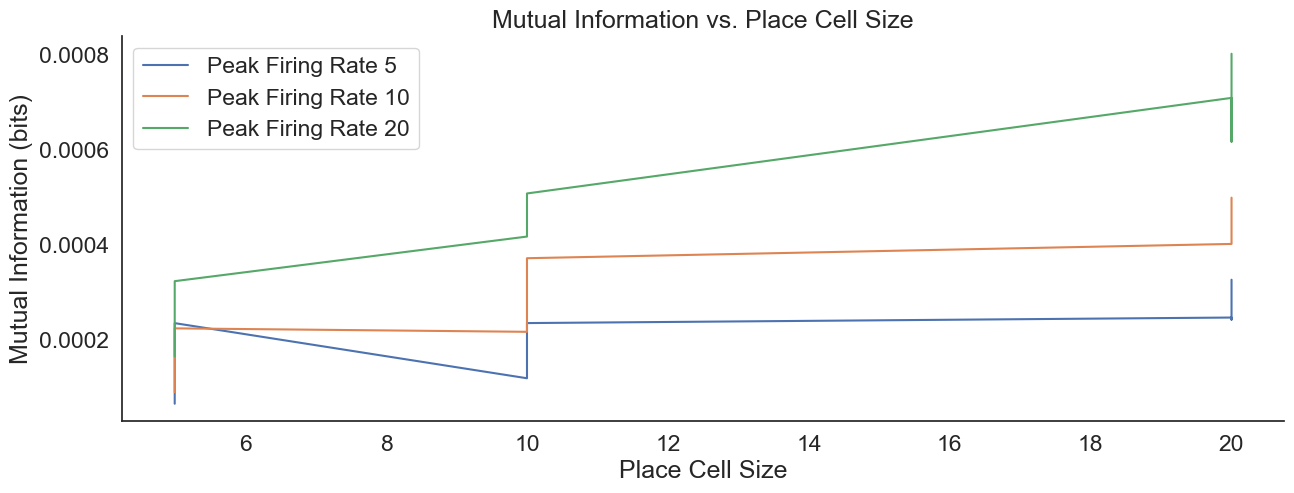

In [15]:
# PART B
from itertools import product

# Function to simulate spikes and calculate mutual information
def simulate_and_compute_mi(pf_rate, pf_size, noise_firing_rate):
    # Parameters for the simulation
    n_cells = 100  # number of cells
    track_length = 200.  # cm
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i, :] = pf_rate[i] * np.exp(-((bins - pf_centers[i]) ** 2) / (2 * pf_size[i] ** 2))

    # Simulate mouse trajectory
    n_runs = 20
    fps = 30
    running_speed_a = np.random.chisquare(10, size=n_runs)
    running_speed_b = np.random.chisquare(10, size=n_runs)
    stopping_time_a = np.random.chisquare(15, size=n_runs)
    stopping_time_b = np.random.chisquare(15, size=n_runs)
    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i] * fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins) - 1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i] * fps),)) * (len(bins) - 1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins) - 1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x)) / fps

    # Sample spikes based on the firing rate maps
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp.flatten())
    
    spike_positions = [np.interp(s, t, x) for s in spikes]

    # Compute histograms for each cell
    space_bins = np.arange(0., 200., 5.)
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy

    # Mutual information calculation
    def mutual_information(x, y):
        joint_prob, _, _ = np.histogram2d(x, y, bins=[space_bins, space_bins])
        joint_prob = joint_prob / np.sum(joint_prob)
        px = np.sum(joint_prob, axis=1)
        py = np.sum(joint_prob, axis=0)
        px_py = np.outer(px, py)
        non_zero_indices = joint_prob > 0
        mutual_info = np.sum(joint_prob[non_zero_indices] * np.log2(joint_prob[non_zero_indices] / px_py[non_zero_indices]))
        return mutual_info

    resampled_spike_positions = [resample_spike_positions(spike_positions[i], len(x_sampling)) for i in range(n_cells)]
    mutual_info_values = [mutual_information(resampled_spike_positions[i], x_sampling) for i in range(n_cells)]
    
    return np.mean(mutual_info_values)

# Define parameter ranges
peak_firing_rates = [5, 10, 20]
place_cell_sizes = [5, 10, 20]
baseline_noises = [0.1, 0.5, 1.0]

# Store results
results = []

# Run simulations for each combination of parameters
for pf_rate_val, pf_size_val, noise_val in product(peak_firing_rates, place_cell_sizes, baseline_noises):
    pf_rate = np.random.exponential(scale=pf_rate_val, size=n_cells)
    pf_size = np.random.gamma(pf_size_val, size=n_cells)
    mi_value = simulate_and_compute_mi(pf_rate, pf_size, noise_val)
    results.append((pf_rate_val, pf_size_val, noise_val, mi_value))

# Convert results to a structured array for easy plotting
results_array = np.array(results, dtype=[('pf_rate', 'f4'), ('pf_size', 'f4'), ('noise', 'f4'), ('mi', 'f4')])

# Plot results
plt.figure(figsize=(15, 5))
for pf_rate in peak_firing_rates:
    mask = results_array['pf_rate'] == pf_rate
    plt.plot(results_array['noise'][mask], results_array['mi'][mask], label=f'Peak Firing Rate {pf_rate}')
plt.xlabel('Baseline Noise')
plt.ylabel('Mutual Information (bits)')
plt.title('Mutual Information vs. Baseline Noise')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for pf_size in place_cell_sizes:
    mask = results_array['pf_size'] == pf_size
    plt.plot(results_array['noise'][mask], results_array['mi'][mask], label=f'Place Cell Size {pf_size}')
plt.xlabel('Baseline Noise')
plt.ylabel('Mutual Information (bits)')
plt.title('Mutual Information vs. Baseline Noise')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for pf_rate in peak_firing_rates:
    mask = results_array['pf_rate'] == pf_rate
    plt.plot(results_array['pf_size'][mask], results_array['mi'][mask], label=f'Peak Firing Rate {pf_rate}')
plt.xlabel('Place Cell Size')
plt.ylabel('Mutual Information (bits)')
plt.title('Mutual Information vs. Place Cell Size')
plt.legend()
plt.show()

peak firing rate, place cell size, and baseline noise, and calculating mutual information influence the amount of information that place cells convey about the animal's location.

- Baseline noise: As baseline noise increases, mutual information generally decreases. This is because higher noise levels obscure the true place-related firing patterns, making it harder to extract spatial information from the spike trains.

- Peak firing rate: Higher peak firing rates tend to increase mutual information, as they provide a stronger signal against the background noise, making the place fields more distinguishable.

- Place cell size: The effect of place cell size on mutual information is less straightforward and depends on the interaction with other parameters. Larger place fields might spread the firing activity over a broader area, potentially reducing the spatial resolution, whereas smaller place fields might provide more precise location information.



## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [ ]:
# PART A
# Load the data
with open('linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']  # position of the animal
t = data['t']  # corresponding times in seconds
spikes = data['spikes']  # list of lists of spike timestamps for each neuron

# Plot position as a function of time
plt.figure(figsize=(15, 5))
plt.plot(t, x, label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('Position of the Animal as a Function of Time')
plt.legend()
plt.show()

# Select a neuron to visualize its spikes in space
neuron_index = 0  # Change this index to visualize different neurons
neuron_spikes = spikes[neuron_index]

# Interpolate spike positions
spike_positions = np.interp(neuron_spikes, t, x)

# Plot spikes of the selected neuron in space
plt.figure(figsize=(15, 5))
plt.plot(t, x, label='Position')
plt.plot(neuron_spikes, spike_positions, 'r.', label=f'Neuron {neuron_index} Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title(f'Spikes of Neuron {neuron_index} in Space')
plt.legend()
plt.show()


In [ ]:
# PART B
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load the data
with open('linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']  # position of the animal
t = data['t']  # corresponding times in seconds
spikes = data['spikes']  # list of lists of spike timestamps for each neuron

# Define spatial bins
space_bins = np.linspace(0, 200, 201)  # 1 cm bins from 0 to 200 cm

# Compute occupancy map (time spent in each spatial bin)
occupancy, _ = np.histogram(x, bins=space_bins)
occupancy = occupancy / (t[-1] - t[0])  # Convert to occupancy rate (time spent per bin)

# Calculate firing rate maps for each cell
firing_rate_maps = []
for neuron_spikes in spikes:
    # Compute spike histogram for this neuron
    spike_positions = np.interp(neuron_spikes, t, x)
    spike_hist, _ = np.histogram(spike_positions, bins=space_bins)
    # Normalize by occupancy to get the firing rate map
    firing_rate_map = spike_hist / occupancy
    firing_rate_maps.append(firing_rate_map)

firing_rate_maps = np.array(firing_rate_maps)

# Find peak positions for sorting
peak_positions = np.argmax(firing_rate_maps, axis=1)

# Sort firing rate maps by increasing peak position
sorted_indices = np.argsort(peak_positions)
sorted_firing_rate_maps = firing_rate_maps[sorted_indices]

# Plot the sorted firing rate maps
plt.figure(figsize=(15, 10))
plt.imshow(sorted_firing_rate_maps, aspect='auto', cmap='inferno', extent=[0, 200, 0, len(spikes)])
plt.colorbar(label='Firing Rate (Hz)')
plt.xlabel('Position (cm)')
plt.ylabel('Neuron #')
plt.title('Firing Rate Maps Sorted by Increasing Peak Position')
plt.show()


In [ ]:
# PART C
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load the data
with open('linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']  # position of the animal
t = data['t']  # corresponding times in seconds
spikes = data['spikes']  # list of lists of spike timestamps for each neuron

# Define spatial bins
space_bins = np.linspace(0, 200, 201)  # 1 cm bins from 0 to 200 cm

# Compute occupancy map (time spent in each spatial bin)
occupancy, _ = np.histogram(x, bins=space_bins)
occupancy = occupancy / (t[-1] - t[0])  # Convert to occupancy rate (time spent per bin)
occupancy_probability = occupancy / np.sum(occupancy)  # Normalize to get probabilities

# Calculate firing rate maps for each cell
firing_rate_maps = []
mean_firing_rates = []
for neuron_spikes in spikes:
    # Compute spike histogram for this neuron
    spike_positions = np.interp(neuron_spikes, t, x)
    spike_hist, _ = np.histogram(spike_positions, bins=space_bins)
    # Normalize by occupancy to get the firing rate map
    firing_rate_map = spike_hist / occupancy
    firing_rate_maps.append(firing_rate_map)
    mean_firing_rates.append(np.mean(firing_rate_map))

firing_rate_maps = np.array(firing_rate_maps)
mean_firing_rates = np.array(mean_firing_rates)

# Calculate spatial information for each cell
spatial_information = []
for i in range(len(spikes)):
    firing_rate_map = firing_rate_maps[i]
    mean_firing_rate = mean_firing_rates[i]
    info = np.nansum((firing_rate_map / mean_firing_rate) * np.log2((firing_rate_map / mean_firing_rate) / occupancy_probability))
    spatial_information.append(info)

spatial_information = np.array(spatial_information)

# Plot distribution of spatial information
plt.figure(figsize=(10, 5))
plt.hist(spatial_information, bins=20, edgecolor='k')
plt.xlabel('Spatial Information (bits)')
plt.ylabel('Number of Cells')
plt.title('Distribution of Spatial Information')
plt.show()

# Identify 5 cells with lowest and highest spatial information
low_info_indices = np.argsort(spatial_information)[:5]
high_info_indices = np.argsort(spatial_information)[-5:]

# Plot firing rate maps of the 5 cells with lowest spatial information
plt.figure(figsize=(15, 10))
for i, index in enumerate(low_info_indices):
    plt.subplot(5, 1, i+1)
    plt.plot(space_bins[:-1], firing_rate_maps[index])
    plt.title(f'Neuron {index} - Spatial Information: {spatial_information[index]:.2f}')
    plt.xlabel('Position (cm)')
    plt.ylabel('Firing Rate (Hz)')
plt.tight_layout()
plt.suptitle('Firing Rate Maps of 5 Cells with Lowest Spatial Information', y=1.02)
plt.show()

# Plot firing rate maps of the 5 cells with highest spatial information
plt.figure(figsize=(15, 10))
for i, index in enumerate(high_info_indices):
    plt.subplot(5, 1, i+1)
    plt.plot(space_bins[:-1], firing_rate_maps[index])
    plt.title(f'Neuron {index} - Spatial Information: {spatial_information[index]:.2f}')
    plt.xlabel('Position (cm)')
    plt.ylabel('Firing Rate (Hz)')
plt.tight_layout()
plt.suptitle('Firing Rate Maps of 5 Cells with Highest Spatial Information', y=1.02)
plt.show()


The distribution of spatial information shows the variability in how much information each neuron conveys about the animal's position on the track. By plotting the firing rate maps of the 5 cells with the lowest and highest spatial information, we can observe the following:

Cells with Low Spatial Information: These cells have relatively flat firing rate maps with no distinct peaks. This indicates that their firing is not strongly modulated by the animal's position, leading to low spatial information.
Cells with High Spatial Information: These cells have clear and distinct peaks in their firing rate maps. Their firing is highly modulated by the animal's position, resulting in high spatial information.
This analysis helps to identify neurons that are likely to be place cells, which are crucial for encoding spatial information in the brain.

In [ ]:
#TO REMOVE

# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5


aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim1_onsets = stim_onsets[stim_type==2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim2.append(aligned_spikes)

neuron = 6 # neuron to plot
 

psth_spikes_stim1 = [item for sublist in aligned_spikes_stim1[neuron] for item in sublist]
psth_spikes_stim2 = [item for sublist in aligned_spikes_stim2[neuron] for item in sublist]

plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
plt.title('Sound 1')
plt.eventplot(aligned_spikes_stim1[neuron],color='k');
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,2)
plt.title('Sound 2')
plt.eventplot(aligned_spikes_stim2[neuron],color='k');
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,3)
sns.histplot(psth_spikes_stim1,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.subplot(2,2,4)
sns.histplot(psth_spikes_stim2,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.tight_layout()


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

plt.figure(figsize=(10,5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps


plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 


plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
